## Install the package dependencies before running this notebook

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [2]:
device = 'cpu'

## Create a Torch.Dataset class for the training dataset

In [3]:
from glob import glob
import pickle5
import numpy as np

ROOT_PATH = "C:/Users/Administrator/cse151b-spring2022/argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle5.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle5.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

        return torch.from_numpy(inputs).float(), torch.from_numpy(outputs).long()

    if split=="test":
    
        return torch.from_numpy(inputs).float(), torch.from_numpy(np.array([]))

    

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None, device='cpu'):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.split = split
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
        self.inputs = self.inputs.to(device)
        self.outputs = self.outputs.to(device)
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        if self.split == 'train':
            data = (self.inputs[idx], self.outputs[idx])
        if self.split == 'test':
            data = self.inputs[idx]
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split, device=device)

## Create a DataLoader class for training

In [4]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [5]:
test_dataset = ArgoverseDataset(city=city, split='test', device=device)
test_loader = DataLoader(test_dataset,batch_size=batch_sz)

# Linear Regression

In [6]:
# Fourier transform from 50 to 60 secs.
inputs = [np.array(signal.resample(i[0], 60)) for i in train_loader.dataset]
outputs = [np.array(i[1]) for i in train_loader.dataset]

In [7]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(inputs, outputs, test_size=0.30)

In [8]:
# Add time as a feature and flatten

def preproc(arr):
    out_arr = []
    for i in arr:
        counter = 0
        for j in i:
            bro = np.append(j, counter)
            counter += 1
            out_arr.append(bro)
    return out_arr

In [9]:
X_train = preproc(X_train_raw)
y_train = preproc(y_train_raw)
X_test = preproc(X_test_raw)
y_test = preproc(y_test_raw)

In [10]:
reg = LinearRegression().fit(X_train, y_train)

In [11]:
y_pred = reg.predict(X_test)

In [12]:
# reshape both predictions and test set back to original 
changed = np.array([i[:-1] for i in y_pred])
good_shape_preds = np.split(changed, len(changed)/60)

changed_test = np.array([i[:-1] for i in y_test])
good_shape_preds_test_y = np.split(changed_test, len(changed_test)/60)

In [13]:
# Flatten each subarray to calculate subarray
preds = []
for i in good_shape_preds:
    preds.append(i.flatten())

flat_test = []
for i in good_shape_preds_test_y:
    flat_test.append(i.flatten())

In [14]:
np.array(preds).shape

(3598, 120)

In [15]:
np.array(flat_test).shape

(3598, 120)

In [16]:
mse = (mean_squared_error(flat_test, preds))
mse

1341.3577448147141

### Linear Regression for Submission

In [17]:
X_train, y_train = preproc(inputs), preproc(outputs)
reg = LinearRegression().fit(X_train, y_train)

In [18]:
def city_pred(city):
    batch_sz = 4  # batch size 
    train_dataset  = ArgoverseDataset(city = city, split ='train', device=device)
    train_loader = DataLoader(train_dataset,batch_size=batch_sz)

    test_dataset = ArgoverseDataset(city=city, split='test', device=device)
    test_loader = DataLoader(test_dataset,batch_size=batch_sz)

    # Fourier transform from 50 to 60 secs.
    inputs = [np.array(signal.resample(i[0], 60)) for i in train_loader.dataset]
    outputs = [np.array(i[1]) for i in train_loader.dataset]

    test_inputs = [np.array(signal.resample(i, 60)) for i in test_loader.dataset]

    X_train, y_train, X_test = preproc(inputs), preproc(outputs), preproc(test_inputs)
    reg = LinearRegression().fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    # reshape both predictions and test set back to original 
    changed = np.array([i[:-1] for i in y_pred])
    good_shape_preds = np.split(changed, len(changed)/60)

    # Flatten each subarray to calculate subarray
    preds = []
    for i in good_shape_preds:
        preds.append(i.flatten())

    df = pd.DataFrame(preds)
    df.columns = ['v' + str(i) for i in (range(120))]
    df['ID'] = [str(i) + '_' + city for i in (range(len(test_loader.dataset)))]
    
    return df
    
    

In [19]:
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

In [20]:
# austin = city_pred('austin')
# miami = city_pred('miami')
# pittsburgh = city_pred('pittsburgh')
# dearborn = city_pred('dearborn')
# washington = city_pred('washington-dc')
palo = city_pred('palo-alto')

In [67]:
#lin_result = pd.concat([austin, miami, pittsburgh, dearborn, washington, palo], axis=0)

In [68]:
#lin_result.to_csv('lin_result.csv', index=False)

In [54]:
sub = pd.read_csv('C:/Users/Administrator/cse151b-spring2022/argo2/sample_submission.csv')
sub

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29839,1682_palo-alto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29840,1683_palo-alto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29841,1684_palo-alto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Sample a batch of data and visualize 

In [21]:
palo

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v111,v112,v113,v114,v115,v116,v117,v118,v119,ID
0,564.569942,1911.264218,563.525517,1912.067027,566.596302,1909.688148,564.284583,1911.470941,566.786050,1909.536384,...,1893.760630,589.086121,1892.376747,586.304584,1894.530564,590.775224,1891.079507,585.110754,1895.460394,0_palo-alto
1,1442.140732,1713.733825,1442.463848,1713.965397,1441.048490,1712.933976,1441.867512,1713.525913,1440.662804,1712.647172,...,1707.054596,1431.974001,1706.509321,1433.119845,1707.343656,1431.223816,1705.967267,1433.547498,1707.656188,1_palo-alto
2,-986.076861,2044.777595,-985.217535,2044.456394,-987.589713,2045.269677,-985.634733,2044.555760,-987.496534,2045.186205,...,2049.793231,-1004.434852,2050.625916,-1002.581130,2050.171616,-1006.565218,2051.804886,-1002.423412,2050.556690,2_palo-alto
3,-1760.213036,2417.255888,-1761.317268,2415.792259,-1757.823873,2418.872138,-1760.451647,2415.867072,-1757.687126,2418.228640,...,2440.847653,-1733.680879,2443.388091,-1736.511455,2440.770637,-1731.129467,2446.353908,-1737.207146,2440.467330,3_palo-alto
4,-1335.023273,2520.947255,-1334.460402,2522.016867,-1334.995314,2518.881709,-1333.969421,2521.255478,-1334.256014,2518.708066,...,2498.752443,-1341.261596,2496.716461,-1340.729418,2499.349393,-1342.285439,2494.519378,-1340.933264,2500.078721,4_palo-alto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,-1365.109226,-439.785424,-1363.918326,-437.817430,-1366.967322,-442.481008,-1364.318524,-438.310013,-1366.657539,-441.865009,...,-473.859617,-1389.393640,-477.508498,-1386.947210,-473.675153,-1392.121119,-481.714471,-1386.613488,-473.117588,1681_palo-alto
1682,134.002872,-57.706305,134.258121,-59.465533,133.565899,-54.952282,134.094497,-58.722881,133.515982,-55.147328,...,-24.308571,127.414841,-21.150633,128.299877,-25.026340,127.563595,-17.730532,129.120907,-26.046279,1682_palo-alto
1683,-1441.767010,2164.408717,-1441.995349,2164.582679,-1441.488687,2164.201229,-1441.968371,2164.564718,-1441.583355,2164.274739,...,2162.182620,-1437.985056,2161.726978,-1438.285116,2161.918461,-1437.270007,2161.115959,-1438.131208,2161.741636,1683_palo-alto
1684,1043.340963,1375.624965,1042.147495,1374.508752,1045.377299,1377.453489,1042.749550,1375.018865,1045.307620,1377.343018,...,1397.206461,1068.877487,1399.268695,1066.167939,1396.778692,1071.353946,1401.538733,1065.513894,1396.173106,1684_palo-alto


tensor([1138.3125, 1138.7170, 1139.2190, 1139.8162, 1140.5007, 1141.2626,
        1142.0831, 1142.9409, 1143.8174, 1144.6935, 1145.5436, 1146.3669,
        1147.1887, 1148.0062, 1148.8143, 1149.6149, 1150.4121, 1151.2047,
        1151.9935, 1152.7781, 1153.5569, 1154.3318, 1155.1016, 1155.8668,
        1156.6260, 1157.3821, 1158.1421, 1158.9077, 1159.6740, 1160.4336,
        1161.1899, 1161.9437, 1162.6926, 1163.4374, 1164.1807, 1164.9236,
        1165.6663, 1166.4102, 1167.1550, 1167.9016, 1168.6528, 1169.4150,
        1170.1875, 1170.9630, 1171.7416, 1172.5194, 1173.3021, 1174.0890,
        1174.8773, 1175.6683])
tensor([-1278, -1278, -1277, -1277, -1276, -1276, -1275, -1275, -1274, -1274,
        -1273, -1272, -1272, -1271, -1271, -1270, -1270, -1269, -1268, -1268,
        -1267, -1267, -1266, -1266, -1265, -1264, -1264, -1263, -1263, -1262,
        -1261, -1261, -1260, -1260, -1259, -1258, -1258, -1257, -1256, -1256,
        -1255, -1255, -1254, -1253, -1253, -1252, -1251, -1251, -

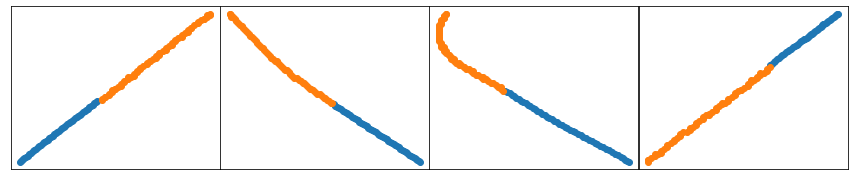

In [184]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()  
    #print(sample_batch) 
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        print(inp[i,:,1])
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        print(out[i,:,0])
        axs[i].scatter(out[i,:,0], out[i,:,1])
        

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break
plt.savefig('figures/ground_truth.jpeg')

In [37]:
a, b = preproc(inputs), preproc(outputs)

In [44]:
forshow = reg.predict(a)

In [45]:
changed = np.array([i[:-1] for i in forshow])
good_shape_preds = np.split(changed, len(changed)/60)

In [46]:
preds = []
for i in good_shape_preds:
    preds.append(i.flatten())

In [156]:
inputs = [torch.tensor(i[0]) for i in train_loader.dataset]

c:\ProgramData\Anaconda3\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [157]:
zipped = DataLoader((list(zip(inputs, good_shape_preds))), batch_size=4)

In [153]:
train_loader.dataset[0][0].shape

torch.Size([50, 2])

In [158]:
zipped.dataset[0][0].shape

torch.Size([50, 2])

tensor([1138.3125, 1138.7170, 1139.2190, 1139.8162, 1140.5007, 1141.2626,
        1142.0831, 1142.9409, 1143.8174, 1144.6935, 1145.5436, 1146.3669,
        1147.1887, 1148.0062, 1148.8143, 1149.6149, 1150.4121, 1151.2047,
        1151.9935, 1152.7781, 1153.5569, 1154.3318, 1155.1016, 1155.8668,
        1156.6260, 1157.3821, 1158.1421, 1158.9077, 1159.6740, 1160.4336,
        1161.1899, 1161.9437, 1162.6926, 1163.4374, 1164.1807, 1164.9236,
        1165.6663, 1166.4102, 1167.1550, 1167.9016, 1168.6528, 1169.4150,
        1170.1875, 1170.9630, 1171.7416, 1172.5194, 1173.3021, 1174.0890,
        1174.8773, 1175.6683])
tensor([-1303.7531, -1304.8765, -1301.8310, -1304.2870, -1301.8597, -1302.7557,
        -1301.9623, -1301.2540, -1301.5462, -1300.2164, -1300.5502, -1299.5800,
        -1299.3145, -1299.0250, -1298.2306, -1298.2501, -1297.4092, -1297.2507,
        -1296.7283, -1296.2246, -1295.9834, -1295.3247, -1295.0964, -1294.5378,
        -1294.1532, -1293.7571, -1293.2680, -1292.9166, -

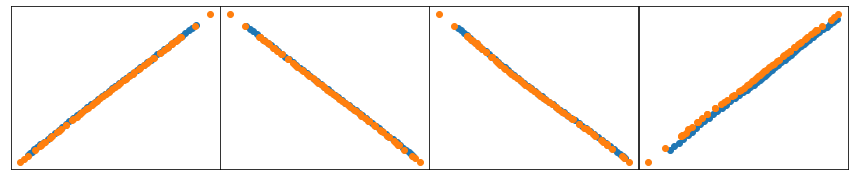

In [185]:
for bab, sample_batch in enumerate(zipped):
    inp, out = sample_batch 
    show_sample_batch(sample_batch)
    break
plt.savefig('figures/linreg_traj.jpeg')